In [1]:
import numpy as np
import matplotlib.pyplot as plt

from argosim.antenna_utils import *
from argosim.plot_utils import *
from argosim.data_utils import *
from argosim.clean import *

# Test the different functions from the argosim `antenna_utils` module.

### Build arrays

In [2]:
# random_antenna_pos(E_lim = 1000, N_lim =1000, U_lim=0) -> (E, N, U)
print('random antenna position: [E, N, U] = {} (meters)'.format(np.around(random_antenna_pos(120., 300, 10), 2)))

random antenna position: [E, N, U] = [51.17 85.71  2.12] (meters)


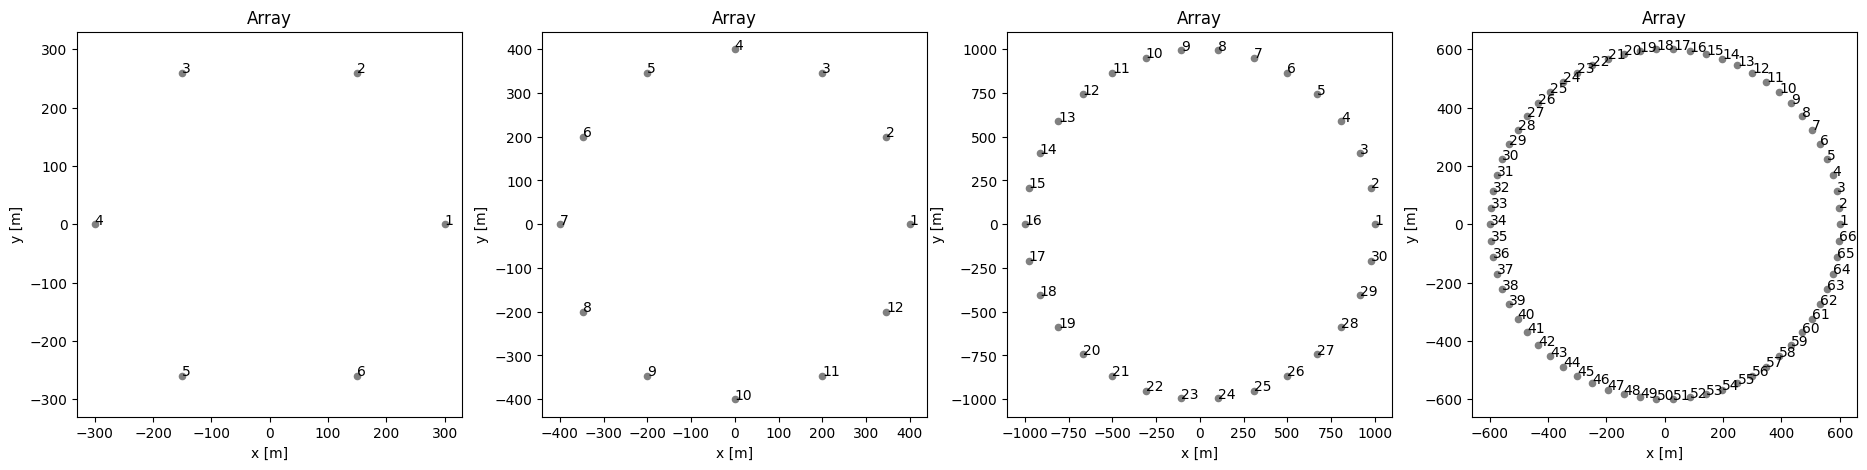

In [3]:
# circular_antenna_arr(n_antenna= 3, r=300) -> [[E1, N1, U1], [E2, N2, U2], ...]
fig, ax = plt.subplots(1, 4, figsize=(23, 5))
for i, (n, r) in enumerate([(6, 300), (12, 400), (30, 1000), (66, 600)]):
    array = circular_antenna_arr(n_antenna=n, r=r)
    plot_antenna_arr(array, ax=ax[i], fig=fig)

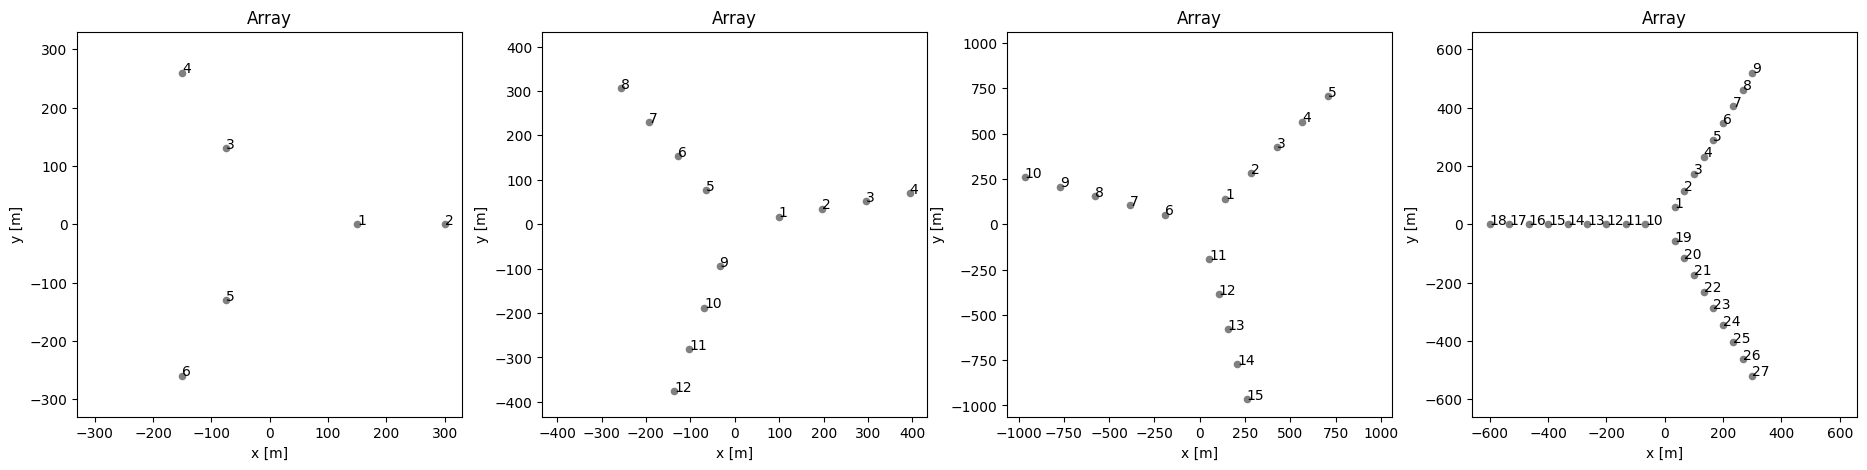

In [4]:
# y_antenna_arr(n_antenna=5, r=500, alpha=0) -> [[E1, N1, U1], [E2, N2, U2], ...]
fig, ax = plt.subplots(1, 4, figsize=(23, 5))
for i, (n, r, alpha) in enumerate([(2, 300, 0), (4, 400, 10), (5, 1000, 45), (9, 600, 60)]):
    array = y_antenna_arr(n_antenna=n, r=r, alpha=alpha)
    plot_antenna_arr(array, ax=ax[i], fig=fig)

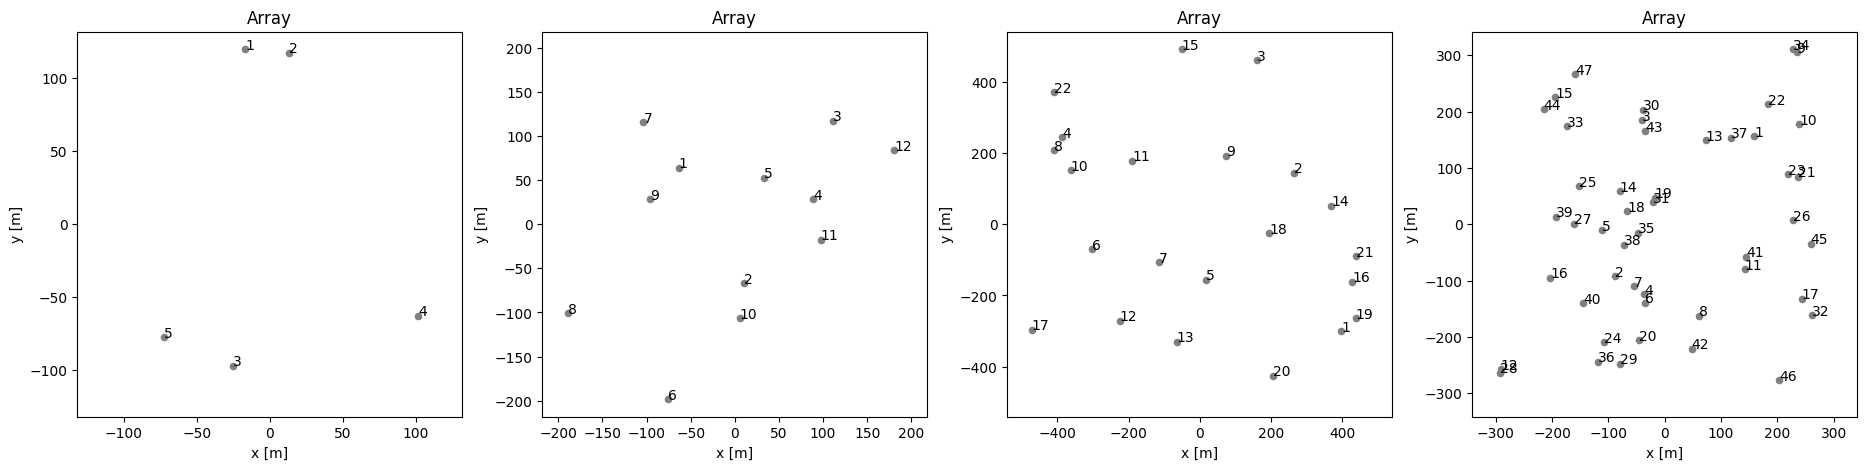

In [5]:
# random_antenna_arr(n_antenna=3, E_lim=1000, N_lim=1000, U_lim=0) -> [[E1, N1, U1], [E2, N2, U2], ...]
fig, ax = plt.subplots(1, 4, figsize=(23, 5))
for i, (n, E_lim, N_lim, U_lim) in enumerate([(5, 300, 300, 0), (12, 400, 400, 10), (22, 1000, 1000, 45), (47, 600, 600, 60)]):
    array = random_antenna_arr(n_antenna=n, E_lim=E_lim, N_lim=N_lim, U_lim=U_lim)
    plot_antenna_arr(array, ax=ax[i], fig=fig)

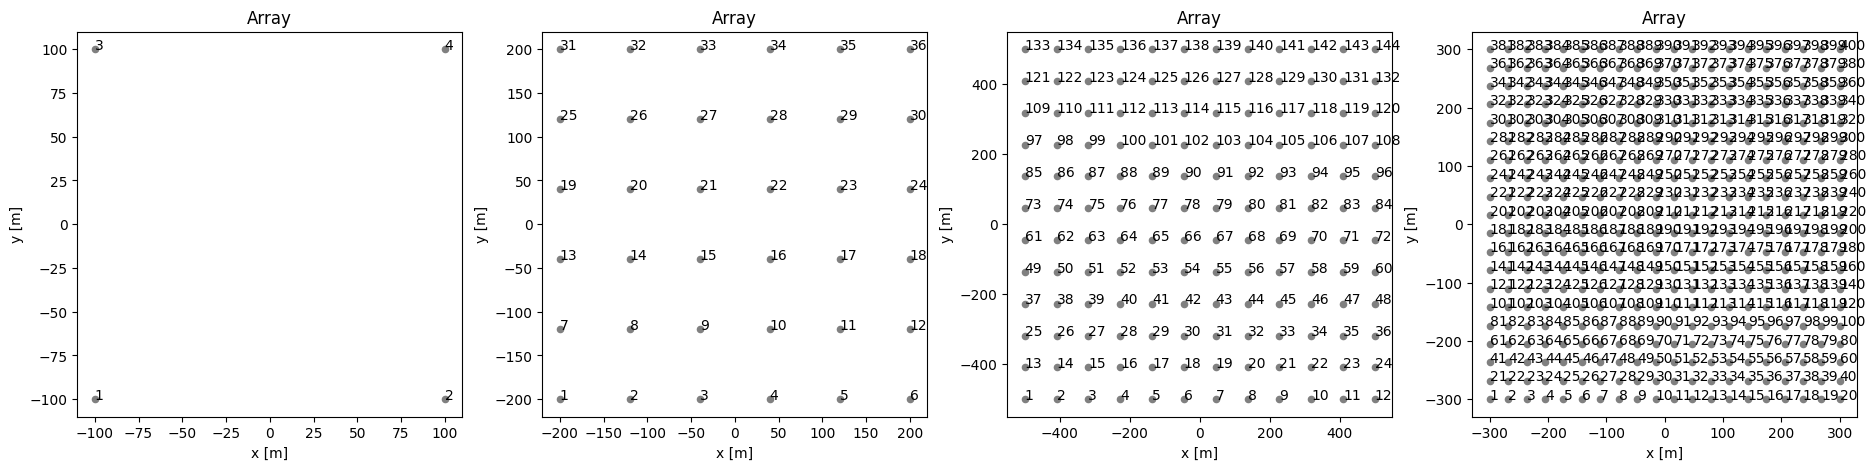

In [6]:
# uni_antenna_array(n_antenna_E=32, n_antenna_N=32, E_lim=800, N_lim=800, U_lim=0) -> [[E1, N1, U1], [E2, N2, U2], ...]
fig, ax = plt.subplots(1, 4, figsize=(23, 5))
for i, (nE, nN, E_lim, N_lim, U_lim) in enumerate([(2, 2, 200, 200, 0), (6,6, 400, 400, 10), (12,12, 1000, 1000, 45), (20,20, 600, 600, 60)]):
    array = uni_antenna_array(n_antenna_E=nE, n_antenna_N=nN, E_lim=E_lim, N_lim=N_lim, U_lim=U_lim)
    plot_antenna_arr(array, ax=ax[i], fig=fig)

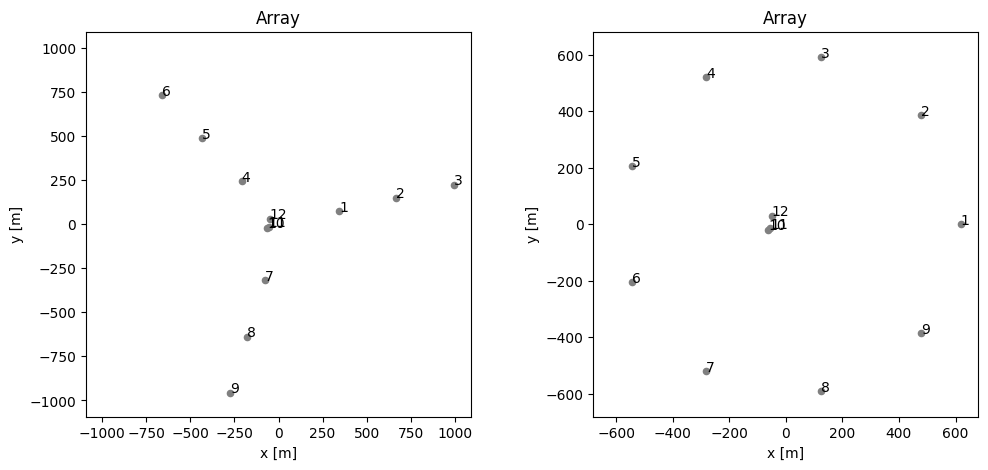

In [7]:
# Combined arrays
array_y = y_antenna_arr(n_antenna=3, r=1000, alpha=13)
array_circ = circular_antenna_arr(n_antenna=9, r=600)
array_rand = random_antenna_arr(n_antenna=3, E_lim=250, N_lim=100, U_lim=0)
array_comby = combine_antenna_arr(array_y,array_rand)
array_combcirc = combine_antenna_arr(array_circ,array_rand)
fig, ax = plt.subplots(1,2, figsize=(12,5))
plot_antenna_arr(array_comby, ax=ax[0], fig=fig)
plot_antenna_arr(array_combcirc, ax=ax[1], fig=fig)

### uvw sampling

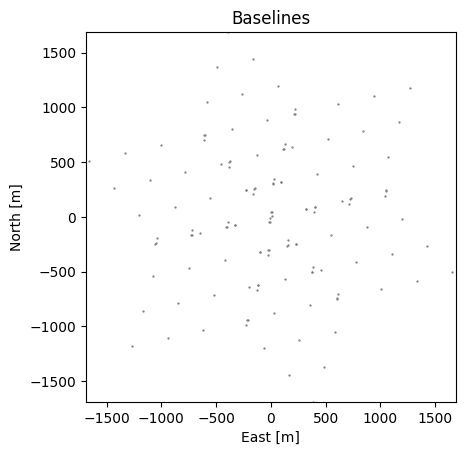

In [17]:
# get_baselines(array) -> [[be1, bn1, bu1], [be2, bn2, bu2], ...]
b_ENU = get_baselines(array_comby)
plot_baselines(b_ENU[:,:2], ENU=True)

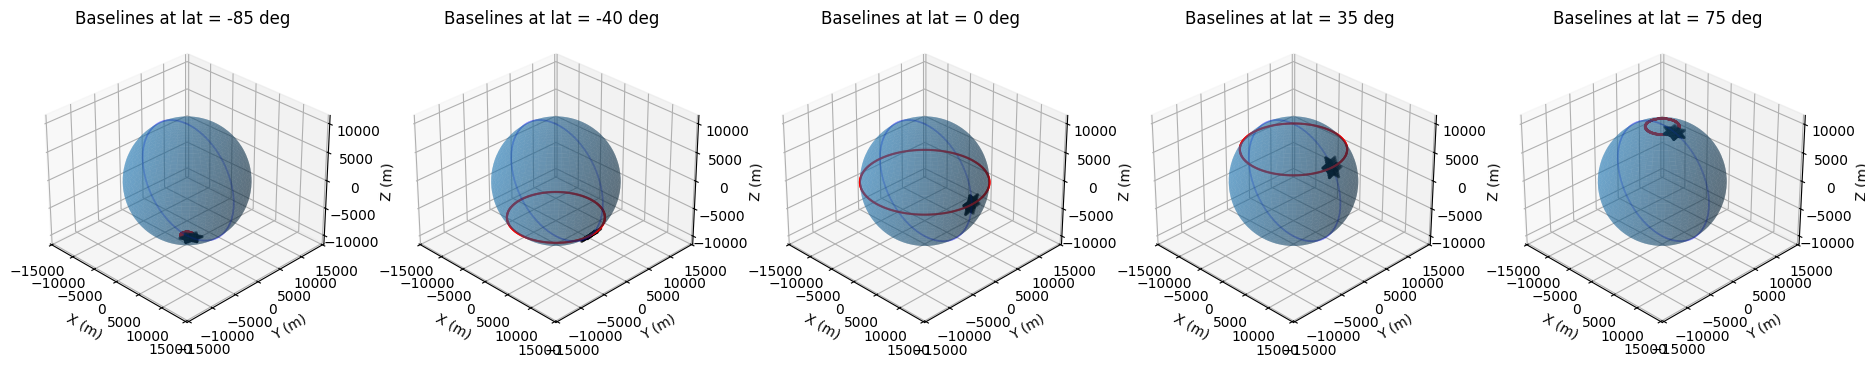

In [9]:
# ENU_to_XYZ(b_ENU, lat = 35./180*np.pi) -> [bx1, bx2, ...], [by1, by2, ...], [bz1, bz2, ...]
fig, ax = plt.subplots(1, 5, figsize=(23, 4), subplot_kw={'projection': '3d'})
l = np.linspace(0, 2 * np.pi, 1000) 
m = np.linspace(0, np.pi, 1000)
R = 10000
x_globe = R * np.outer(np.cos(l), np.sin(m))
y_globe = R * np.outer(np.sin(l), np.sin(m))
z_globe = R * np.outer(np.ones(np.size(l)), np.cos(m))

# Loop on different latitudes (in deg)
for i, lat in enumerate([-85, -40, 0, 35, 75]):
    ax[i].plot_surface(x_globe, y_globe, z_globe, alpha=0.4)
    x_shift = R * np.cos(lat/180*np.pi)
    z_shift = R * np.sin(lat/180*np.pi)
    z_circ = np.where((z_globe[0] - z_shift)**2 < 20**2)
    y_circ = np.where((z_globe[0])**2 < 20**2)
    ax[i].scatter(x_globe[:,z_circ], y_globe[:,z_circ], z_globe[:,z_circ], c='r', s=0.3, alpha=0.2)
    ax[i].scatter(x_globe[:,y_circ], z_globe[:,y_circ], y_globe[:,y_circ] , c='b', s=0.1, alpha=0.05)
    X, Y, Z = ENU_to_XYZ(b_ENU, lat = lat/180*np.pi)
    # ax[i].scatter(X, Y, Z, c='k', s=3)
    ax[i].scatter(X + x_shift, Y, Z + z_shift, c='k', s=2)
    ax[i].set_xlabel('X (m)')
    ax[i].set_ylabel('Y (m)')
    ax[i].set_zlabel('Z (m)')
    ax[i].set_title('Baselines at lat = {} deg'.format(lat))
    ax[i].axis('equal')
    # Observe the array from the source elevation and azimuth
    ax[i].view_init(elev=30, azim=-45)
plt.show()

The array is observed from the source perspective (elevation and azimuth angles). The uv coordinates lie in the plane perpendicular to the line of sigth.

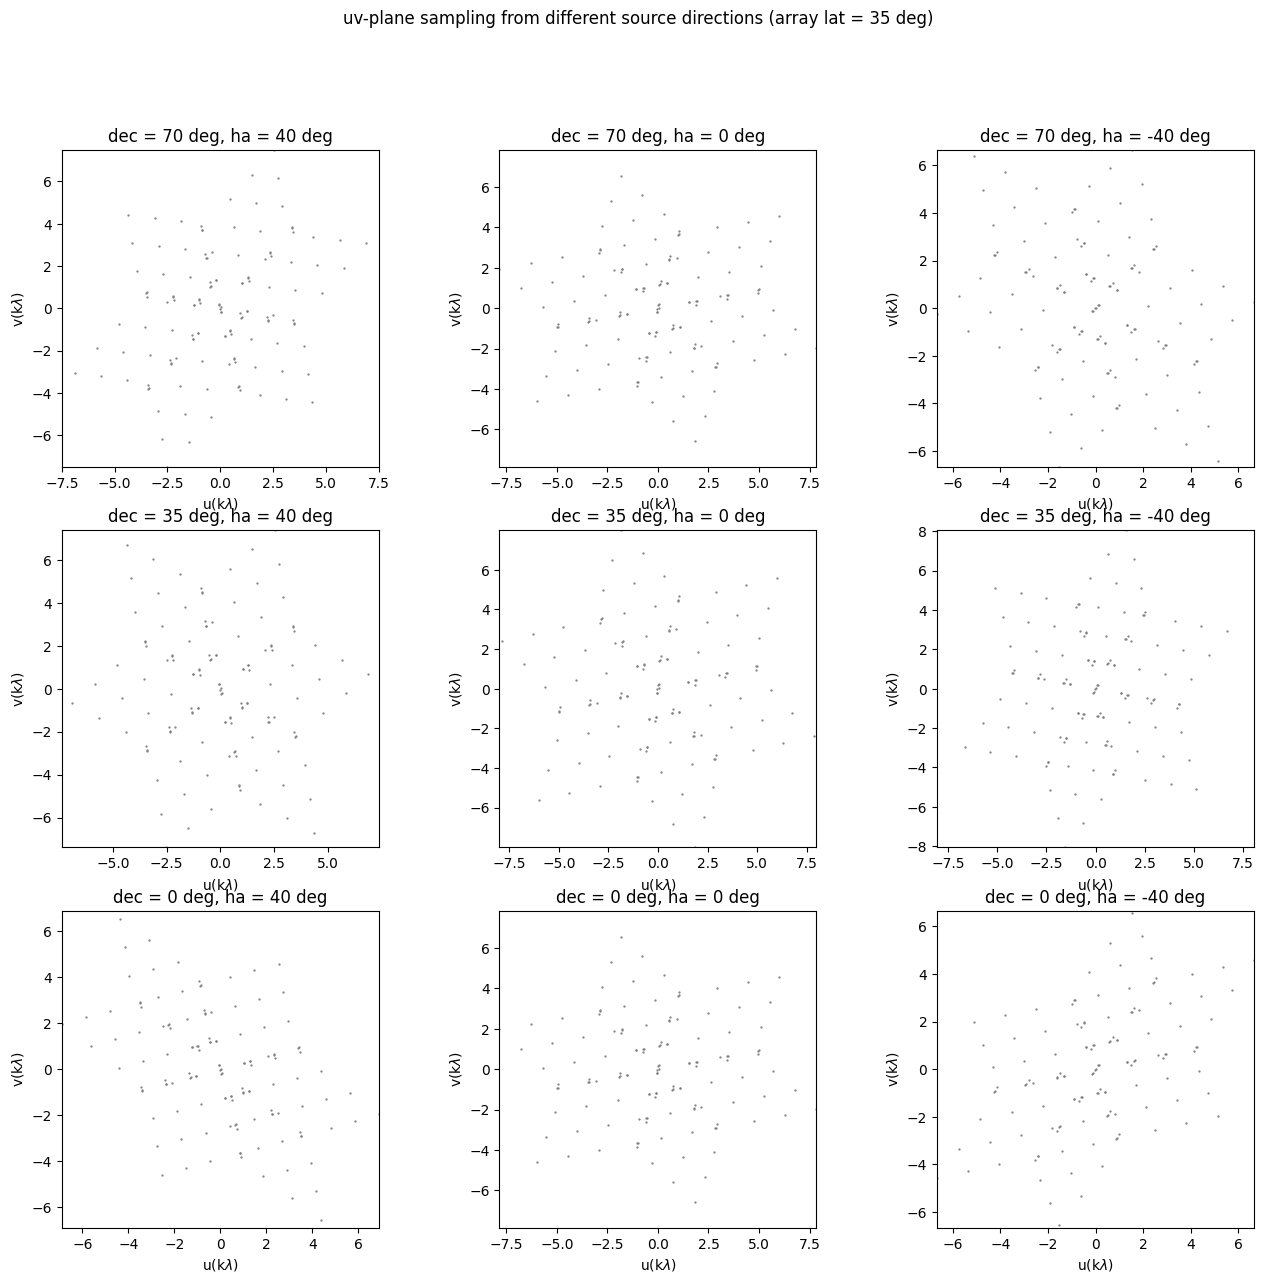

In [10]:
# XYZ_to_uvw(X, Y, Z, dec=30./180*np.pi , ha=0., f=1420e6) -> [u1, u2, ...], [v1, v2, ...], [w1, w2, ...]
X, Y, Z = ENU_to_XYZ(b_ENU, lat = 35/180*np.pi)
fig, ax = plt.subplots(3,3, figsize=(16,14))

# Loop on different declinations (in deg)
for i, dec in enumerate([0, 35, 70]):
    # Loop on different hour angles (in deg)
    for j, ha in enumerate([-40, 0, 40]):
        u, v, w = XYZ_to_uvw(X, Y, Z, dec=dec/180*np.pi , ha=ha/180*np.pi, f=1420e6)
        plot_baselines(np.vstack((u,v)).T, ax=ax[2-i,2-j], fig=fig)
        ax[2-i,2-j].set_title('dec = {} deg, ha = {} deg'.format(dec, ha))
fig.suptitle('uv-plane sampling from different source directions (array lat = 35 deg)')
plt.show()

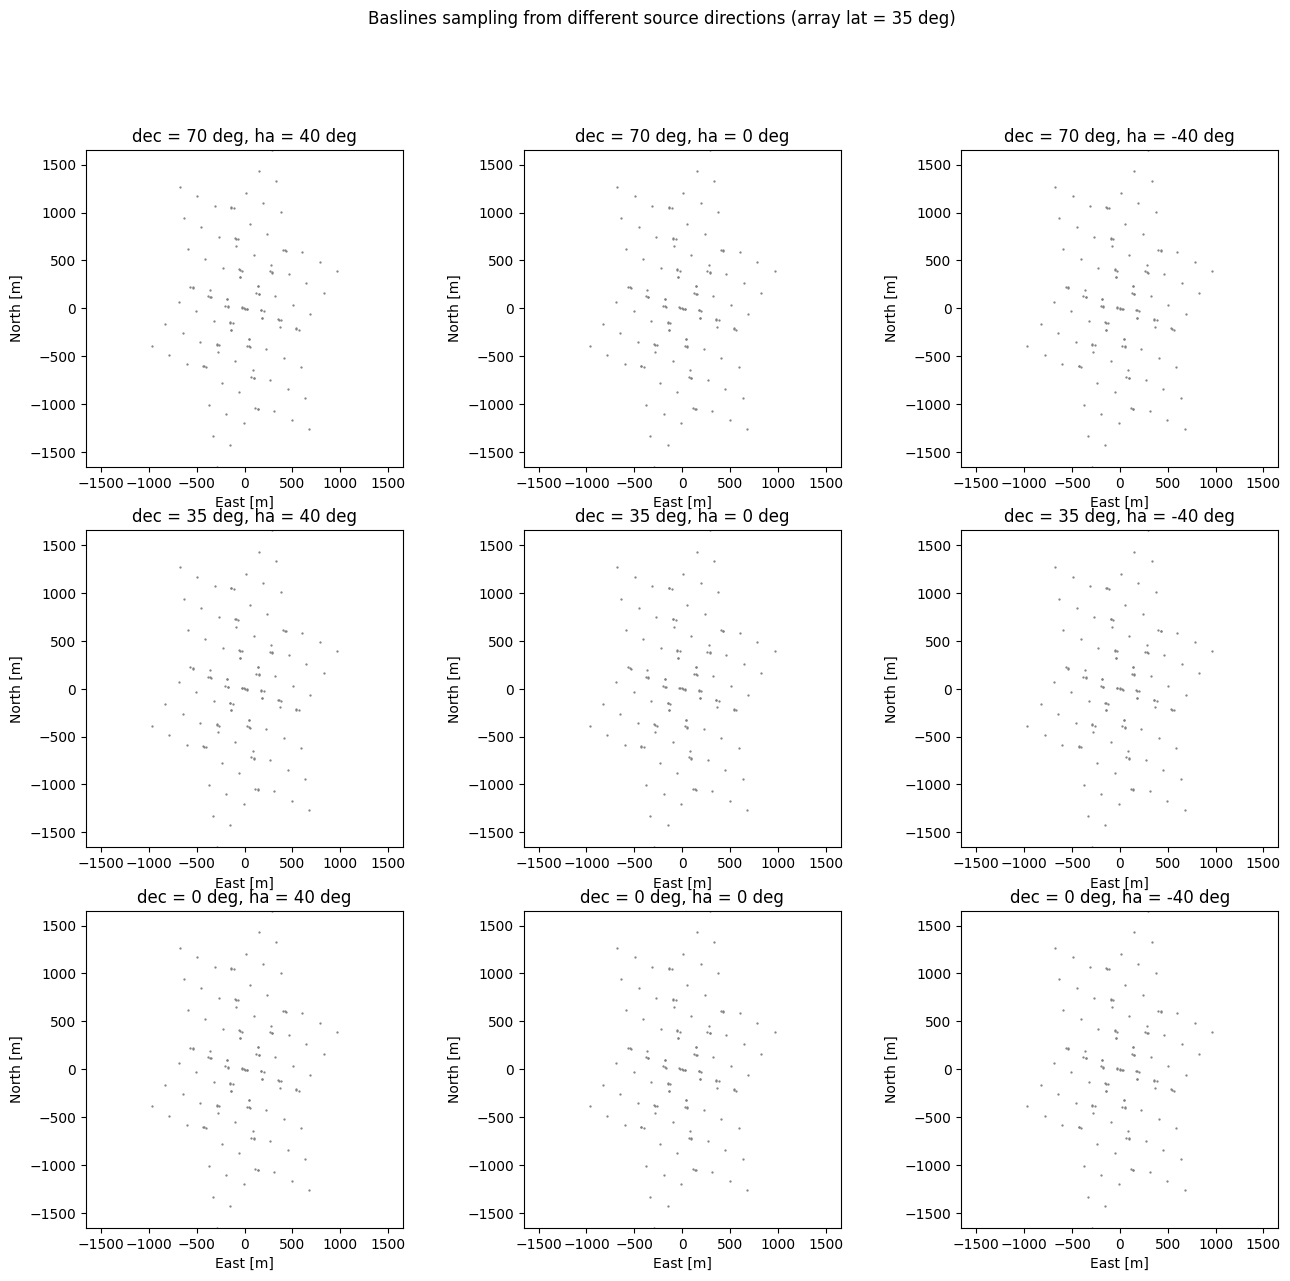

In [11]:
# XYZ_to_uvw(X, Y, Z, dec=30./180*np.pi , ha=0., f=1420e6) -> [u1, u2, ...], [v1, v2, ...], [w1, w2, ...]
X, Y, Z = ENU_to_XYZ(b_ENU, lat = 35/180*np.pi)
fig, ax = plt.subplots(3,3, figsize=(16,14))

# Loop on different declinations (in deg)
for i, dec in enumerate([0, 35, 70]):
    # Loop on different hour angles (in deg)
    for j, ha in enumerate([-40, 0, 40]):
        u, v, w = XYZ_to_uvw(X, Y, Z, dec=dec/180*np.pi , ha=ha/180*np.pi, f=1420e6)
        plot_baselines(np.vstack((X,Y)).T, ax=ax[2-i,2-j], fig=fig, ENU=True)
        ax[2-i,2-j].set_title('dec = {} deg, ha = {} deg'.format(dec, ha))
fig.suptitle('Baslines sampling from different source directions (array lat = 35 deg)')
plt.show()

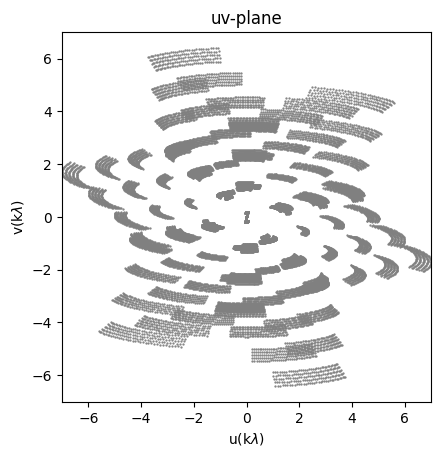

In [12]:
# uv_track_multiband(b_ENU, lat = 35./180*np.pi, dec=35./180*np.pi, track_time=0., t_0=0., n_times = 1 , f=1420e6, df=0., n_freqs=1) -> [u1, v1, ...], [u2, v2, ...], ...
# Multiband parameters (frequencies in Hz)
bandwidth = 100e6 
n_freqs = 5 
f = 1200e6 

# Source tracking parameters (angles in radians)
source_decl = 10./180*np.pi
array_lat = 35./180*np.pi
track_time = 3
delta_t = 5/60 # 300 segs
t_0 = -0.5
n_times = int(track_time/delta_t)

b_ENU = get_baselines(array_comby)

track = uv_track_multiband(b_ENU, array_lat, source_decl, track_time, t_0, n_times, f, bandwidth, n_freqs)

plot_baselines(track)

# Baselines histogram

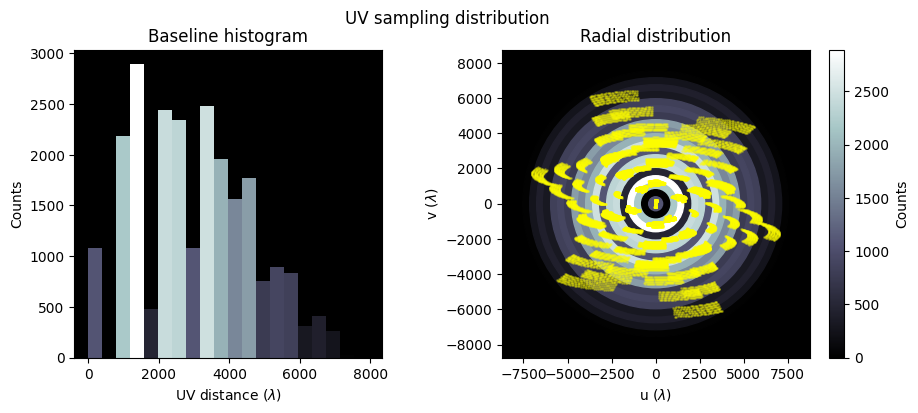

In [13]:
baseline_hist = plot_uv_hist(track)

In [19]:
print(baseline_hist)

(array([1080.,    0., 2184., 2890.,  482., 2436., 2340., 1084., 2476.,
       1956., 1560., 1766.,  760.,  898.,  830.,  314.,  408.,  268.,
         28.,    0.]), array([   0.        ,  397.19062667,  794.38125333, 1191.57188   ,
       1588.76250666, 1985.95313333, 2383.14375999, 2780.33438666,
       3177.52501332, 3574.71563999, 3971.90626665, 4369.09689332,
       4766.28751998, 5163.47814665, 5560.66877331, 5957.85939998,
       6355.05002664, 6752.24065331, 7149.43127997, 7546.62190664,
       7943.8125333 ]), <BarContainer object of 20 artists>)


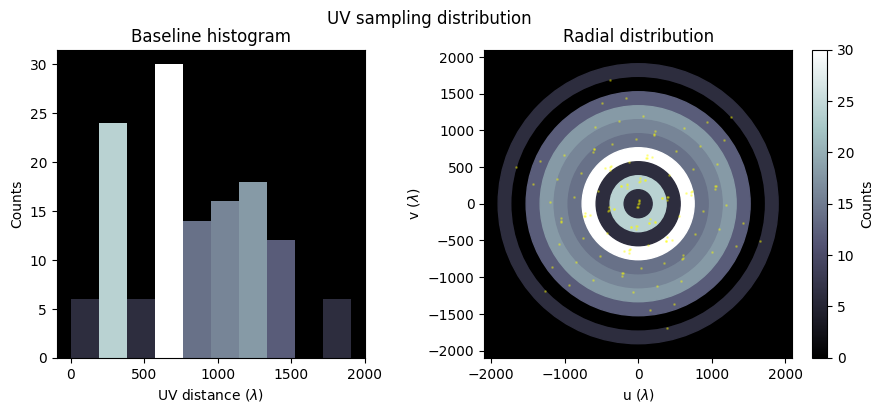

In [24]:
_ = plot_uv_hist(b_ENU, bins=10)